# Experiment B: Within-Tier Engagement Rate Classification
## LinkedIn Engagement Prediction — TrendPilot

**Experiment:** Assign class labels using per-tier percentile thresholds.
**Question:** Is this content above average *for a creator of this size*?

---

## Motivation

In the baseline engagement rate model (NB11), `follower_tier` ranked #1 in
feature importance because the global class thresholds created a structural
shortcut: large accounts almost always land in Class 0 (low global rate),
micro accounts almost always in Class 2 (high global rate). The model learned
this tier → class mapping rather than content quality signals.

This experiment restructures how classes are assigned:

**Instead of:** Is this post's rate above average *globally*?
**We ask:** Is this post's rate above average *for creators of this size*?

Each tier gets its own 33rd/67th percentile thresholds derived from the
training set. A micro-creator post is judged against other micro-creators.
A large-creator post is judged against other large-creators.

This eliminates the tier → class structural shortcut, forcing `follower_tier`
and `log_followers` to earn their importance from within-tier content patterns.

## What to look for
- Is per-tier Macro F1 more consistent? (less gap between 0.89 large vs 0.30 small)
- Does overall Macro F1 hold up, or does removing the shortcut hurt performance?
- Do content features rise in importance relative to follower proxies?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score, ConfusionMatrixDisplay
)
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
print('Libraries loaded.')

Libraries loaded.


## 1. Load Data

In [2]:
data = pd.read_csv('../data/selected_features_data.csv')
print(f'Shape: {data.shape}')
print(f'Columns ({len(data.columns)}): {list(data.columns)}')

Shape: (772, 94)
Columns (94): ['name', 'content', 'reactions', 'comments', 'time_spent', 'location', 'followers', 'influencer_avg_comments', 'reactions_per_sentiment', 'influencer_avg_engagement', 'comments_vs_influencer_avg', 'reactions_vs_influencer_avg', 'influencer_total_engagement', 'reactions_per_word', 'comments_per_word', 'sentiment_compound', 'text_difficult_words_count', 'total_engagement_elements', 'readability_flesch_kincaid', 'comment_to_reaction_ratio', 'base_score_capped', 'text_lexical_diversity', 'influencer_avg_sentiment', 'influencer_std_comments', 'readability_gunning_fog', 'sentence_count', 'text_avg_sentence_length', 'topic_count', 'influencer_std_reactions', 'sentiment_x_readability', 'ner_location_count', 'style_question_marks', 'ner_org_count', 'style_has_parentheses', 'influencer_avg_base_score', 'ner_person_count', 'ner_date_count', 'influencer_consistency_reactions', 'unique_emoji_count', 'hashtag_count_extracted', 'style_quote_marks', 'has_aspirational', '

## 2. Build Engagement Rate Target

```
engagement_rate = (reactions + comments) / (followers / 1000)
```

Units: total engagements per 1,000 followers.  
A creator with 10k followers getting 100 reactions â†’ rate = 100 / 10 = 10.0  
A creator with 1M followers getting 10,000 reactions â†’ rate = 10,000 / 1000 = 10.0  
Both produced equally resonant content â€” the rate reflects this.

In [3]:
df = data.copy()

# Guard against zero followers
df['followers'] = df['followers'].clip(lower=1)

df['engagement_rate'] = (df['reactions'] + df['comments']) / (df['followers'] / 1000)

print('Engagement rate summary:')
print(df['engagement_rate'].describe().round(3))
print(f'\nMedian: {df["engagement_rate"].median():.2f} engagements per 1k followers')
print(f'90th pct: {df["engagement_rate"].quantile(0.9):.2f}')

Engagement rate summary:
count     772.000
mean       31.310
std        86.321
min         0.010
25%         1.177
50%         5.879
75%        25.499
max      1132.075
Name: engagement_rate, dtype: float64

Median: 5.88 engagements per 1k followers
90th pct: 75.75


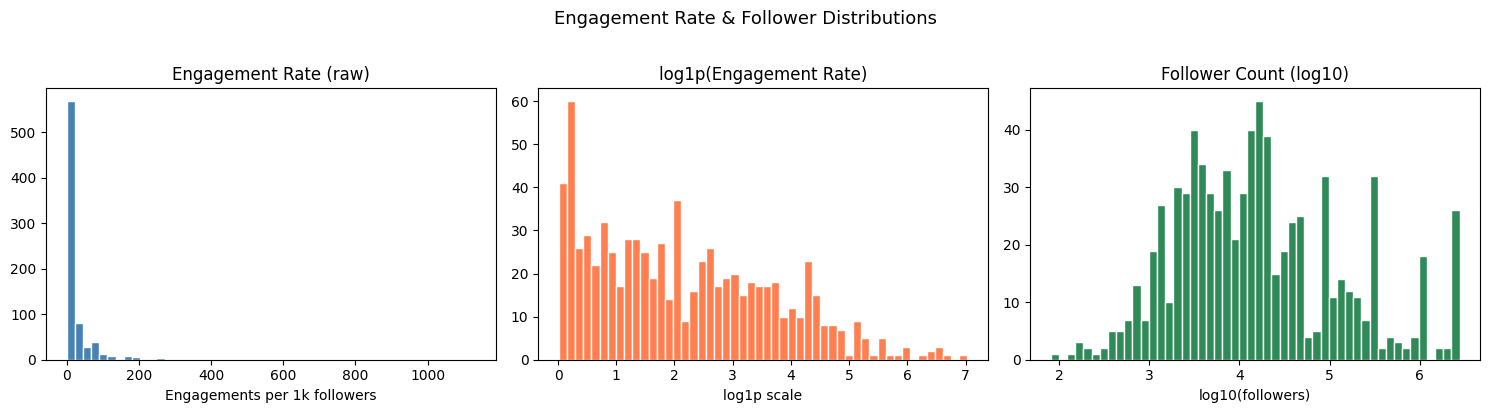

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Raw distribution
axes[0].hist(df['engagement_rate'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Engagement Rate (raw)')
axes[0].set_xlabel('Engagements per 1k followers')

# Log distribution
axes[1].hist(np.log1p(df['engagement_rate']), bins=50, color='coral', edgecolor='white')
axes[1].set_title('log1p(Engagement Rate)')
axes[1].set_xlabel('log1p scale')

# Follower distribution
axes[2].hist(np.log10(df['followers']+1), bins=50, color='seagreen', edgecolor='white')
axes[2].set_title('Follower Count (log10)')
axes[2].set_xlabel('log10(followers)')

plt.suptitle('Engagement Rate & Follower Distributions', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('../data/11_distributions.png', dpi=100, bbox_inches='tight')
plt.show()

## 3. Train / Test Split FIRST

Split before assigning class labels so that percentile thresholds
are computed from training data only â€” preventing any leakage from
test distribution into the class boundaries.

In [5]:
# We'll use a temporary rough quantile split for stratification, then refine
df['_tmp_class'] = pd.qcut(df['engagement_rate'], q=3, labels=[0, 1, 2])

df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=RANDOM_STATE,
    stratify=df['_tmp_class']
)
df_train = df_train.copy().reset_index(drop=True)
df_test  = df_test.copy().reset_index(drop=True)
df_train.drop(columns=['_tmp_class'], inplace=True)
df_test.drop(columns=['_tmp_class'], inplace=True)

print(f'Train: {len(df_train)} posts | Test: {len(df_test)} posts')
print(f'Train authors: {df_train["name"].nunique()} | Test authors: {df_test["name"].nunique()}')

Train: 617 posts | Test: 155 posts
Train authors: 417 | Test authors: 123


## 4. Assign 3-Class Labels — Per-Tier Percentiles

**Key change from NB11:** Instead of one global p33/p67, each follower tier
gets its own thresholds derived from training data only.

A micro-creator post is classified relative to other micro-creator posts.
A large-creator post is classified relative to other large-creator posts.

This removes the structural shortcut where tier alone predicted class,
forcing the model to find within-tier content signals.


In [6]:
# Build follower tier first (needed for threshold computation)
for df_ in [df_train, df_test]:
    df_['follower_tier'] = pd.cut(
        df_['followers'],
        bins=[0, 10_000, 50_000, 200_000, np.inf],
        labels=[0, 1, 2, 3], include_lowest=True
    ).astype(int)

tier_labels_full = {0: 'micro (<10k)', 1: 'small (10k-50k)',
                    2: 'medium (50k-200k)', 3: 'large (>200k)'}

def assign_class(series, p33, p67):
    bins = [-np.inf, p33, p67, np.inf]
    return pd.cut(series, bins=bins, labels=[0, 1, 2],
                  include_lowest=True).astype(int)

# Initialise columns
df_train['engagement_class'] = -1
df_test['engagement_class']  = -1

# Per-tier thresholds from TRAINING DATA ONLY
tier_thresholds = {}
print('Per-tier thresholds (derived from training set only):')
print(f'{"Tier":22s}  {"n_train":>7}  {"p33":>8}  {"p67":>8}')

for tid in [0, 1, 2, 3]:
    train_mask = df_train['follower_tier'] == tid
    test_mask  = df_test['follower_tier']  == tid

    tier_rates = df_train.loc[train_mask, 'engagement_rate']
    p33 = tier_rates.quantile(1/3)
    p67 = tier_rates.quantile(2/3)
    tier_thresholds[tid] = (p33, p67)

    df_train.loc[train_mask, 'engagement_class'] = assign_class(tier_rates, p33, p67)
    if test_mask.sum() > 0:
        df_test.loc[test_mask, 'engagement_class'] = assign_class(
            df_test.loc[test_mask, 'engagement_rate'], p33, p67)

    print(f'  {tier_labels_full[tid]:22s}  {train_mask.sum():>7}  {p33:>8.3f}  {p67:>8.3f}')

# Use micro thresholds as representative for LABEL_NAMES display
p33_global = df_train['engagement_rate'].quantile(1/3)
p67_global = df_train['engagement_rate'].quantile(2/3)
LABEL_NAMES = {0: 'Below avg (tier)', 1: 'Average (tier)', 2: 'Above avg (tier)'}

print(f'\nClass distribution — TRAINING (within-tier labels):')
for c in [0, 1, 2]:
    n = (df_train['engagement_class'] == c).sum()
    print(f'  Class {c} {LABEL_NAMES[c]:22s}: {n} ({n/len(df_train)*100:.1f}%)')

print(f'\nClass distribution — TEST (within-tier labels):')
for c in [0, 1, 2]:
    n = (df_test['engagement_class'] == c).sum()
    print(f'  Class {c} {LABEL_NAMES[c]:22s}: {n} ({n/len(df_test)*100:.1f}%)')

print(f'\nNB11 comparison (global thresholds): p33={p33_global:.3f}, p67={p67_global:.3f}')
print('NB11b uses per-tier thresholds — each tier has its own class boundaries')


Per-tier thresholds (derived from training set only):
Tier                    n_train       p33       p67
  micro (<10k)                276    10.915    43.188
  small (10k-50k)             181     1.388     7.146
  medium (50k-200k)            73     0.665     2.904
  large (>200k)                87     0.217     1.011

Class distribution — TRAINING (within-tier labels):
  Class 0 Below avg (tier)      : 207 (33.5%)
  Class 1 Average (tier)        : 205 (33.2%)
  Class 2 Above avg (tier)      : 205 (33.2%)

Class distribution — TEST (within-tier labels):
  Class 0 Below avg (tier)      : 54 (34.8%)
  Class 1 Average (tier)        : 47 (30.3%)
  Class 2 Above avg (tier)      : 54 (34.8%)

NB11 comparison (global thresholds): p33=2.174, p67=15.162
NB11b uses per-tier thresholds — each tier has its own class boundaries


## 5. Follower Tier Features

`log_followers` is added as a continuous follower proxy.
`follower_tier` was already computed in the class assignment step above.

Both are kept as features — but because class labels are now within-tier,
these features can no longer act as a shortcut to class prediction.
The model must find within-tier content signals to distinguish
high from low performers within each creator size.


In [7]:
# follower_tier already created in the labels cell above
# Add log_followers as continuous proxy
def add_follower_features(df_):
    df_ = df_.copy()
    df_['log_followers'] = np.log1p(df_['followers'])
    return df_

df_train = add_follower_features(df_train)
df_test  = add_follower_features(df_test)

print('Follower tier distribution (full dataset):')
tier_labels_map = {0:'micro (<10k)', 1:'small (10k-50k)',
                   2:'medium (50k-200k)', 3:'large (>200k)'}
all_tiers = pd.concat([df_train, df_test])['follower_tier'].value_counts().sort_index()
for t, n in all_tiers.items():
    print(f'  {tier_labels_map[t]:22s}: {n} ({n/772*100:.1f}%)')


Follower tier distribution (full dataset):
  micro (<10k)          : 345 (44.7%)
  small (10k-50k)       : 225 (29.1%)
  medium (50k-200k)     : 92 (11.9%)
  large (>200k)         : 110 (14.2%)


## 6. Feature Set â€” Drop Leaky Columns

In [8]:
# â”€â”€ Columns to DROP (leakage or direct engagement signals) â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€
DROP_COLS = [
    # Raw targets / used in target construction
    'reactions', 'comments', 'followers', 'engagement_rate', 'engagement_class',
    # Derived directly from reactions/comments (same-post leakage)
    'base_score_capped',
    'reactions_per_word', 'comments_per_word', 'reactions_per_sentiment',
    'comment_to_reaction_ratio',
    # Influencer-history features (aggregated from same dataset â€” data leakage)
    'influencer_avg_reactions', 'influencer_std_reactions', 'influencer_median_reactions',
    'influencer_avg_comments', 'influencer_std_comments', 'influencer_median_comments',
    'influencer_avg_base_score', 'influencer_avg_sentiment',
    'influencer_post_count', 'influencer_total_engagement', 'influencer_avg_engagement',
    'influencer_consistency_reactions',
    'reactions_vs_influencer_avg', 'comments_vs_influencer_avg',
    # Metadata / text / identifiers â€” not ML features
    'name', 'content', 'time_spent', 'location',
]

# Only drop cols that actually exist
drop_existing = [c for c in DROP_COLS if c in df_train.columns]
print(f'Dropping {len(drop_existing)} columns (leakage/metadata):')
for c in drop_existing:
    print(f'  {c}')

# â”€â”€ Keep all remaining numeric / binary columns as features â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€
all_cols = df_train.columns.tolist()
feature_cols = [c for c in all_cols if c not in drop_existing and c != 'engagement_class']

# Verify all are numeric
non_numeric = [c for c in feature_cols if not pd.api.types.is_numeric_dtype(df_train[c])]
if non_numeric:
    print(f'\nNon-numeric columns removed from features: {non_numeric}')
    feature_cols = [c for c in feature_cols if c not in non_numeric]

print(f'\nTotal features: {len(feature_cols)}')
print('Feature columns:', feature_cols)

Dropping 25 columns (leakage/metadata):
  reactions
  comments
  followers
  engagement_rate
  engagement_class
  base_score_capped
  reactions_per_word
  comments_per_word
  reactions_per_sentiment
  comment_to_reaction_ratio
  influencer_std_reactions
  influencer_avg_comments
  influencer_std_comments
  influencer_avg_base_score
  influencer_avg_sentiment
  influencer_post_count
  influencer_total_engagement
  influencer_avg_engagement
  influencer_consistency_reactions
  reactions_vs_influencer_avg
  comments_vs_influencer_avg
  name
  content
  time_spent
  location

Total features: 73
Feature columns: ['sentiment_compound', 'text_difficult_words_count', 'total_engagement_elements', 'readability_flesch_kincaid', 'text_lexical_diversity', 'readability_gunning_fog', 'sentence_count', 'text_avg_sentence_length', 'topic_count', 'sentiment_x_readability', 'ner_location_count', 'style_question_marks', 'ner_org_count', 'style_has_parentheses', 'ner_person_count', 'ner_date_count', 'uniqu

In [9]:
X_train = df_train[feature_cols].fillna(0)
X_test  = df_test[feature_cols].fillna(0)
y_train = df_train['engagement_class']
y_test  = df_test['engagement_class']

print(f'X_train: {X_train.shape}  |  X_test: {X_test.shape}')
print(f'y_train value counts: {y_train.value_counts().sort_index().to_dict()}')
print(f'y_test  value counts: {y_test.value_counts().sort_index().to_dict()}')

X_train: (617, 73)  |  X_test: (155, 73)
y_train value counts: {0: 207, 1: 205, 2: 205}
y_test  value counts: {0: 54, 1: 47, 2: 54}


## 7. Baseline Models

Run all three classifiers with standard hyperparameters first to
establish baselines. Class-balanced weighting applied throughout.

In [10]:
def evaluate(model, X_te, y_te, name='Model', verbose=True):
    yp = model.predict(X_te)
    mf1 = f1_score(y_te, yp, average='macro')
    acc = accuracy_score(y_te, yp)
    if verbose:
        print(f'  [{name}]  Macro F1={mf1:.4f}  Acc={acc:.4f}')
        print(classification_report(
            y_te, yp,
            target_names=[LABEL_NAMES[i] for i in [0, 1, 2]],
            zero_division=0
        ))
    return dict(model=name, macro_f1=round(mf1, 4), acc=round(acc, 4))

results = []
sw = compute_sample_weight('balanced', y_train)

In [11]:
print('â”€' * 60)
print('Random Forest (baseline)')
rf = RandomForestClassifier(
    n_estimators=400, max_depth=10,
    min_samples_split=20, min_samples_leaf=10,
    class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1
)
rf.fit(X_train, y_train)
results.append(evaluate(rf, X_test, y_test, 'RandomForest_base'))

â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€
Random Forest (baseline)
  [RandomForest_base]  Macro F1=0.4042  Acc=0.4194
                  precision    recall  f1-score   support

Below avg (tier)       0.49      0.57      0.53        54
  Average (tier)       0.25      0.21      0.23        47
Above avg (tier)       0.46      0.44      0.45        54

        accuracy                           0.42       155
       macro avg       0.40      0.41      0.40       155
    weighted avg       0.41      0.42      0.41       155



In [12]:
print('â”€' * 60)
print('XGBoost (baseline)')
xgb_b = xgb.XGBClassifier(
    n_estimators=400, max_depth=5, learning_rate=0.05,
    min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
    eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1, verbosity=0
)
xgb_b.fit(X_train, y_train, sample_weight=sw)
results.append(evaluate(xgb_b, X_test, y_test, 'XGBoost_base'))

â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€
XGBoost (baseline)
  [XGBoost_base]  Macro F1=0.4362  Acc=0.4452
                  precision    recall  f1-score   support

Below avg (tier)       0.48      0.57      0.52        54
  Average (tier)       0.32      0.30      0.31        47
Above avg (tier)       0.52      0.44      0.48        54

        accuracy                           0.45       155
       macro avg       0.44      0.44      0.44       155
    weighted avg       0.44      0.45      0.44       155



In [13]:
print('â”€' * 60)
print('LightGBM (baseline)')
lgb_b = lgb.LGBMClassifier(
    n_estimators=400, max_depth=5, learning_rate=0.05,
    num_leaves=20, min_child_samples=20,
    subsample=0.8, colsample_bytree=0.8,
    class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1, verbose=-1
)
lgb_b.fit(X_train, y_train)
results.append(evaluate(lgb_b, X_test, y_test, 'LightGBM_base'))

â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€â”€
LightGBM (baseline)
  [LightGBM_base]  Macro F1=0.4747  Acc=0.4774
                  precision    recall  f1-score   support

Below avg (tier)       0.51      0.54      0.52        54
  Average (tier)       0.38      0.40      0.39        47
Above avg (tier)       0.54      0.48      0.51        54

        accuracy                           0.48       155
       macro avg       0.48      0.47      0.47       155
    weighted avg       0.48      0.48      0.48       155



## 8. Hyperparameter Tuning â€” XGBoost + LightGBM

RandomizedSearchCV with stratified 5-fold CV, scored on macro F1.

In [14]:
print('Tuning XGBoost (40 iterations, 5-fold CV)...')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

xgb_grid = {
    'n_estimators':     [200, 400, 600],
    'max_depth':        [3, 4, 5, 6],
    'learning_rate':    [0.01, 0.05, 0.1],
    'min_child_weight': [3, 5, 10],
    'subsample':        [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma':            [0, 0.1, 0.3],
}

xgb_search = RandomizedSearchCV(
    xgb.XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=1, verbosity=0),
    xgb_grid, n_iter=40, cv=skf, scoring='f1_macro',
    random_state=RANDOM_STATE, n_jobs=-1, verbose=1
)
xgb_search.fit(X_train, y_train, sample_weight=sw)

print(f'\nXGBoost â€” Best CV Macro F1: {xgb_search.best_score_:.4f}')
print(f'Best params: {xgb_search.best_params_}')

xgb_tuned = xgb_search.best_estimator_
results.append(evaluate(xgb_tuned, X_test, y_test, 'XGBoost_tuned'))

Tuning XGBoost (40 iterations, 5-fold CV)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

XGBoost â€” Best CV Macro F1: 0.4898
Best params: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
  [XGBoost_tuned]  Macro F1=0.4353  Acc=0.4452
                  precision    recall  f1-score   support

Below avg (tier)       0.52      0.57      0.54        54
  Average (tier)       0.30      0.28      0.29        47
Above avg (tier)       0.49      0.46      0.48        54

        accuracy                           0.45       155
       macro avg       0.43      0.44      0.44       155
    weighted avg       0.44      0.45      0.44       155



In [15]:
print('Tuning LightGBM (30 iterations, 5-fold CV)...')
lgb_grid = {
    'n_estimators':      [200, 400, 600],
    'max_depth':         [3, 4, 5, 6],
    'learning_rate':     [0.01, 0.05, 0.1],
    'num_leaves':        [15, 20, 31, 50],
    'min_child_samples': [10, 20, 30],
    'subsample':         [0.7, 0.8, 0.9],
    'colsample_bytree':  [0.6, 0.8, 1.0],
    'reg_alpha':         [0, 0.1, 0.5],
    'reg_lambda':        [1, 2, 5],
}

lgb_search = RandomizedSearchCV(
    lgb.LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=1, verbose=-1),
    lgb_grid, n_iter=30, cv=skf, scoring='f1_macro',
    random_state=RANDOM_STATE, n_jobs=-1, verbose=1
)
lgb_search.fit(X_train, y_train)

print(f'\nLightGBM â€” Best CV Macro F1: {lgb_search.best_score_:.4f}')
print(f'Best params: {lgb_search.best_params_}')

lgb_tuned = lgb_search.best_estimator_
results.append(evaluate(lgb_tuned, X_test, y_test, 'LightGBM_tuned'))

Tuning LightGBM (30 iterations, 5-fold CV)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

LightGBM â€” Best CV Macro F1: 0.4773
Best params: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 10, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
  [LightGBM_tuned]  Macro F1=0.4413  Acc=0.4452
                  precision    recall  f1-score   support

Below avg (tier)       0.51      0.56      0.53        54
  Average (tier)       0.34      0.38      0.36        47
Above avg (tier)       0.49      0.39      0.43        54

        accuracy                           0.45       155
       macro avg       0.45      0.44      0.44       155
    weighted avg       0.45      0.45      0.44       155



## 9. Cross-Validation â€” Best Model

In [16]:
# Identify best model by macro F1
results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['macro_f1'].idxmax()]
print(f'Best model so far: {best_row["model"]} â€” Macro F1 = {best_row["macro_f1"]}')

# Run 5-fold CV for the best model
if 'XGBoost' in best_row['model']:
    best_params = xgb_search.best_params_
    cv_model = xgb.XGBClassifier(**best_params, eval_metric='mlogloss',
                                   random_state=RANDOM_STATE, n_jobs=1, verbosity=0)
    label = 'XGBoost_tuned'
else:
    best_params = lgb_search.best_params_
    cv_model = lgb.LGBMClassifier(**best_params, class_weight='balanced',
                                   random_state=RANDOM_STATE, n_jobs=1, verbose=-1)
    label = 'LightGBM_tuned'

cv_scores = cross_val_score(
    cv_model, X_train, y_train,
    cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro', n_jobs=-1
)
print(f'\n5-Fold CV ({label}):')
print(f'  Per-fold Macro F1: {cv_scores.round(4)}')
print(f'  Mean: {cv_scores.mean():.4f} Â± {cv_scores.std():.4f}')
print(f'  Random baseline: ~0.333 (3-class random)')

Best model so far: LightGBM_base â€” Macro F1 = 0.4747

5-Fold CV (LightGBM_tuned):
  Per-fold Macro F1: [0.4561 0.4992 0.4623 0.4595 0.5093]
  Mean: 0.4773 Â± 0.0223
  Random baseline: ~0.333 (3-class random)


## 10. Confusion Matrix â€” Best Model

confusion_matrix(y_test, y_pred):
 [[30 13 11]
 [18 18 11]
 [11 22 21]]
confusion_matrix(y_test, y_pred) â€” Normalised (Recall):
 [[0.55555556 0.24074074 0.2037037 ]
 [0.38297872 0.38297872 0.23404255]
 [0.2037037  0.40740741 0.38888889]]


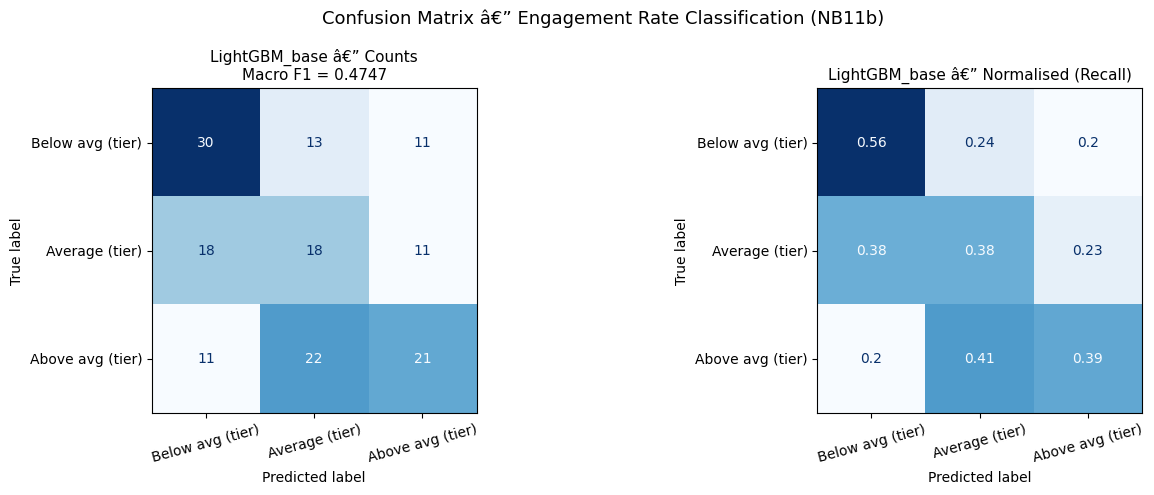

Saved: ../data/11b_confusion_matrix.png


In [17]:
if 'XGBoost' in best_row['model']:
    best_model = xgb_tuned
else:
    best_model = lgb_tuned

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("confusion_matrix(y_test, y_pred):\n", cm)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute counts
disp = ConfusionMatrixDisplay(cm, display_labels=[LABEL_NAMES[i] for i in [0, 1, 2]])
disp.plot(ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title(f'{best_row["model"]} â€” Counts\nMacro F1 = {best_row["macro_f1"]:.4f}', fontsize=11)
axes[0].tick_params(axis='x', labelrotation=15)

# Normalised (recall per class)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
print("confusion_matrix(y_test, y_pred) â€” Normalised (Recall):\n", cm_norm)
disp2 = ConfusionMatrixDisplay(cm_norm.round(2), display_labels=[LABEL_NAMES[i] for i in [0, 1, 2]])
disp2.plot(ax=axes[1], colorbar=False, cmap='Blues')
axes[1].set_title(f'{best_row["model"]} â€” Normalised (Recall)', fontsize=11)
axes[1].tick_params(axis='x', labelrotation=15)

plt.suptitle('Confusion Matrix â€” Engagement Rate Classification (NB11b)', fontsize=13)
plt.tight_layout()
plt.savefig('../data/11b_confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()
print('Saved: ../data/11b_confusion_matrix.png')

## 11. Feature Importance

Top 25 Features:
                   feature  importance
             log_followers         970
  text_avg_sentence_length         715
    text_lexical_diversity         638
   readability_gunning_fog         571
   sentiment_x_readability         508
readability_flesch_kincaid         478
        sentiment_compound         454
text_difficult_words_count         433
          ner_person_count         344
         style_quote_marks         331
             ner_org_count         308
   hashtag_count_extracted         279
            sentence_count         260
        style_number_count         254
        unique_emoji_count         251
      style_all_caps_words         231
            ner_date_count         226
      style_question_marks         209
 total_engagement_elements         192
        ner_location_count         167
               emoji_count         151
   style_parentheses_count         138
   style_exclamation_marks         128
               topic_count         121
        

<Figure size 1000x900 with 0 Axes>

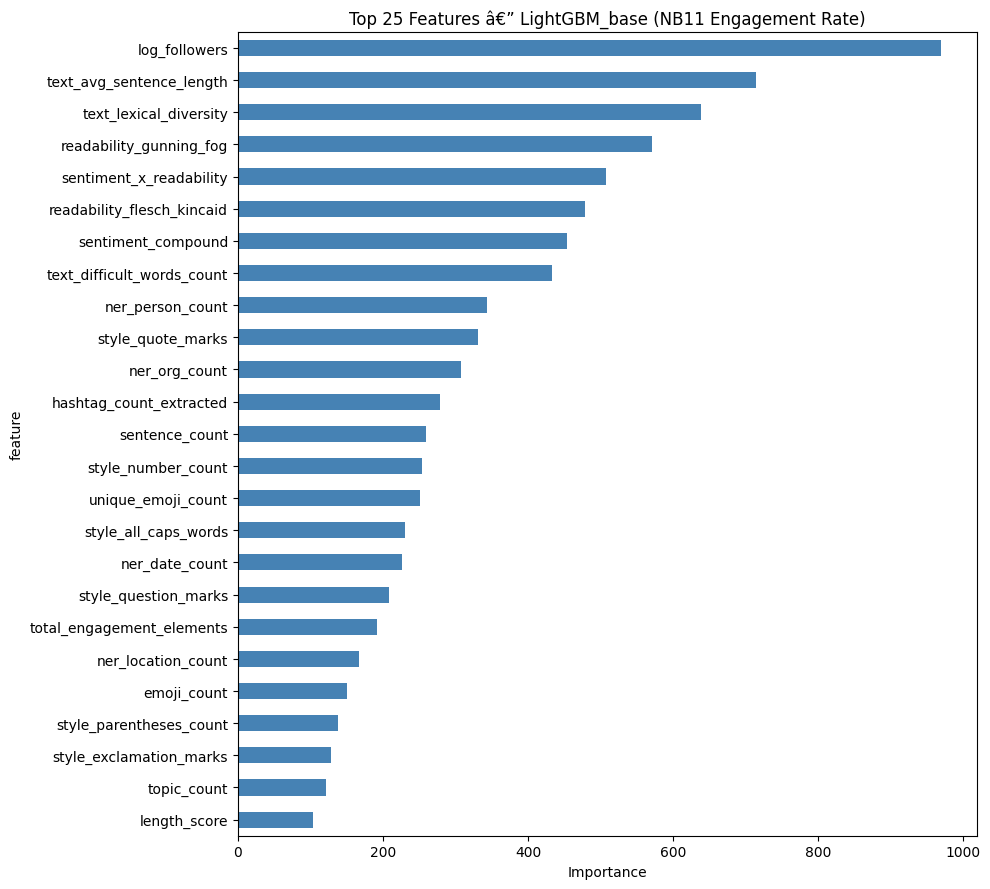

Saved: ../data/11b_feature_importance.png


In [18]:
if hasattr(best_model, 'feature_importances_'):
    imp = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).reset_index(drop=True)

    print('Top 25 Features:')
    print(imp.head(25).to_string(index=False))

    # Highlight follower proxies
    for feat in ['log_followers', 'follower_tier']:
        row = imp[imp['feature'] == feat]
        if not row.empty:
            rank = row.index[0] + 1
            val  = row['importance'].values[0]
            print(f'\n  {feat}: rank #{rank}, importance={val:.4f}')

    plt.figure(figsize=(10, 9))
    imp.head(25).sort_values('importance').plot(
        x='feature', y='importance', kind='barh',
        figsize=(10, 9), color='steelblue', legend=False
    )
    plt.title(f'Top 25 Features â€” {best_row["model"]} (NB11 Engagement Rate)', fontsize=12)
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig('../data/11b_feature_importance.png', dpi=100, bbox_inches='tight')
    plt.show()
    print('Saved: ../data/11b_feature_importance.png')

## 12. Evaluation by Follower Tier

Key validation: does the model work across all creator sizes?  
A good engagement-rate model should classify content quality fairly
for micro influencers and macro influencers alike.

In [19]:
tier_labels_map = {0: 'micro (<10k)', 1: 'small (10k-50k)',
                   2: 'medium (50k-200k)', 3: 'large (>200k)'}

# NB11 baseline tier F1 scores for comparison
nb11_tier_f1 = {
    0: 0.3942,  # micro
    1: 0.3016,  # small
    2: 0.3630,  # medium
    3: 0.8889,  # large
}

tier_results = []
print('=' * 75)
print('Macro F1 by Follower Tier — NB11b vs NB11 (global thresholds)')
print('=' * 75)
print(f'{"Tier":22s}  {"n":>4}  {"NB11b F1":>9}  {"NB11 F1":>9}  {"Delta":>7}')
print('-' * 75)

for tier_id, tier_name in tier_labels_map.items():
    mask = df_test['follower_tier'] == tier_id
    n = mask.sum()
    if n == 0 or y_test[mask].nunique() < 2:
        print(f'  {tier_name:22s}: {n} posts — skipped (too few samples or classes)')
        continue

    yp_t = best_model.predict(X_test[mask])
    mf1  = f1_score(y_test[mask], yp_t, average='macro', zero_division=0)
    acc  = accuracy_score(y_test[mask], yp_t)
    nb11_f1 = nb11_tier_f1.get(tier_id, float('nan'))
    delta = mf1 - nb11_f1
    delta_str = f'+{delta:.4f}' if delta >= 0 else f'{delta:.4f}'
    print(f'  {tier_name:22s}  {n:>4}  {mf1:>9.4f}  {nb11_f1:>9.4f}  {delta_str:>7}')
    tier_results.append({'tier': tier_name, 'n': n, 'macro_f1_11b': round(mf1, 4),
                         'macro_f1_11': nb11_f1, 'delta': round(delta, 4)})

print('-' * 75)
print(f'  {"Overall":22s}  {len(y_test):>4}  '
      f'{best_row["macro_f1"]:>9.4f}  {0.5734:>9.4f}  '
      f'{"+" if best_row["macro_f1"]-0.5734>=0 else ""}{best_row["macro_f1"]-0.5734:.4f}')
print()
print('Goal: NB11b tier F1 should be more CONSISTENT (less variance across tiers)')
print('NB11 had extreme variance: large=0.89 vs small=0.30 — model learned tier, not content')


Macro F1 by Follower Tier — NB11b vs NB11 (global thresholds)
Tier                       n   NB11b F1    NB11 F1    Delta
---------------------------------------------------------------------------
  micro (<10k)              69     0.5078     0.3942  +0.1136
  small (10k-50k)           44     0.3333     0.3016  +0.0317
  medium (50k-200k)         19     0.2513     0.3630  -0.1117
  large (>200k)             23     0.6004     0.8889  -0.2885
---------------------------------------------------------------------------
  Overall                  155     0.4747     0.5734  -0.0987

Goal: NB11b tier F1 should be more CONSISTENT (less variance across tiers)
NB11 had extreme variance: large=0.89 vs small=0.30 — model learned tier, not content


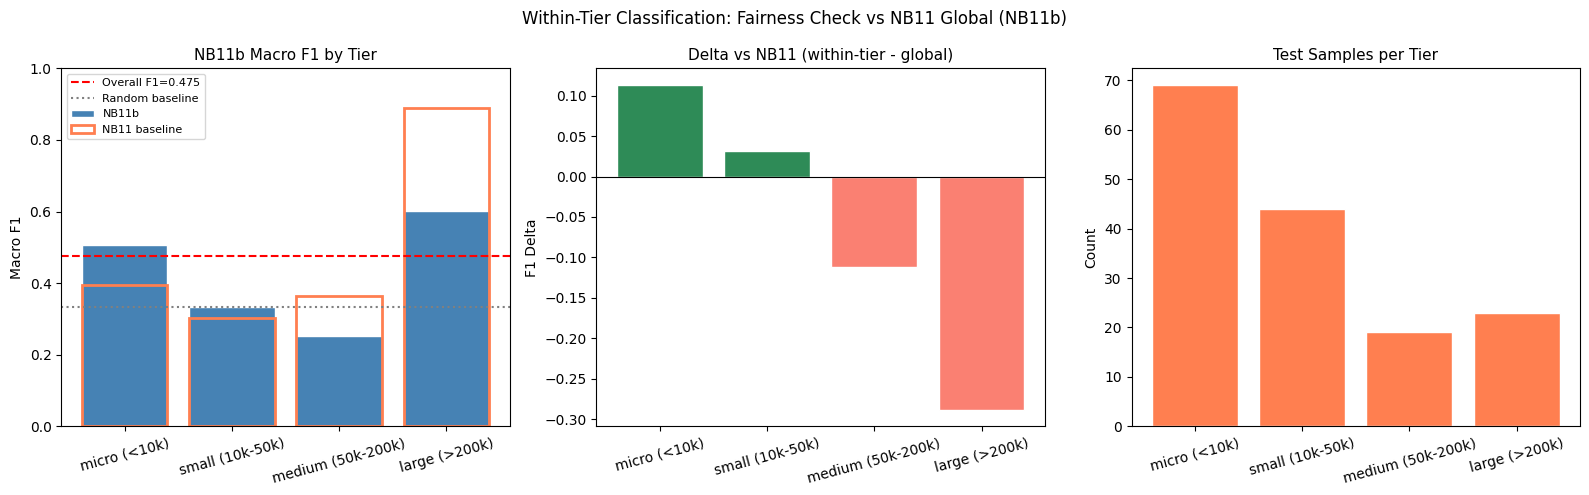

Saved: ../data/11b_tier_evaluation.png


In [20]:
if tier_results:
    tier_df = pd.DataFrame(tier_results)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # NB11b Macro F1 by tier
    axes[0].bar(tier_df["tier"], tier_df["macro_f1_11b"], color="steelblue", edgecolor="white", label="NB11b")
    axes[0].bar(tier_df["tier"], tier_df["macro_f1_11"], color="none", edgecolor="coral", linewidth=2, label="NB11 baseline")
    axes[0].axhline(best_row["macro_f1"], color="red", linestyle="--", label=f'Overall F1={best_row["macro_f1"]:.3f}')
    axes[0].axhline(0.333, color="gray", linestyle=":", label="Random baseline")
    axes[0].set_title("NB11b Macro F1 by Tier", fontsize=11)
    axes[0].set_ylabel("Macro F1")
    axes[0].set_ylim(0, 1)
    axes[0].legend(fontsize=8)
    axes[0].tick_params(axis="x", labelrotation=15)

    # Delta vs NB11
    colors = ["seagreen" if d >= 0 else "salmon" for d in tier_df["delta"]]
    axes[1].bar(tier_df["tier"], tier_df["delta"], color=colors, edgecolor="white")
    axes[1].axhline(0, color="black", linewidth=0.8)
    axes[1].set_title("Delta vs NB11 (within-tier - global)", fontsize=11)
    axes[1].set_ylabel("F1 Delta")
    axes[1].tick_params(axis="x", labelrotation=15)

    # Sample counts
    axes[2].bar(tier_df["tier"], tier_df["n"], color="coral", edgecolor="white")
    axes[2].set_title("Test Samples per Tier", fontsize=11)
    axes[2].set_ylabel("Count")
    axes[2].tick_params(axis="x", labelrotation=15)

    plt.suptitle("Within-Tier Classification: Fairness Check vs NB11 Global (NB11b)", fontsize=12)
    plt.tight_layout()
    plt.savefig("../data/11b_tier_evaluation.png", dpi=100, bbox_inches="tight")
    plt.show()
    print("Saved: ../data/11b_tier_evaluation.png")


## 13. Full Results Summary

In [21]:
print('=' * 65)
print('NB11b — WITHIN-TIER ENGAGEMENT RATE CLASSIFICATION')
print('Experiment B: Per-tier class thresholds')
print('=' * 65)
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

print(f'\nPer-tier thresholds used:')
for tid, (p33, p67) in tier_thresholds.items():
    print(f'  {tier_labels_full[tid]:22s}: p33={p33:.3f}, p67={p67:.3f}')

print(f'\nNB11 (global thresholds):  XGBoost_tuned Macro F1 = 0.5734')
print(f'NB11b (per-tier):          Best = {best_row["model"]} Macro F1 = {best_row["macro_f1"]}')
print(f'Random baseline:           ~0.333')


NB11b — WITHIN-TIER ENGAGEMENT RATE CLASSIFICATION
Experiment B: Per-tier class thresholds
            model  macro_f1    acc
RandomForest_base    0.4042 0.4194
     XGBoost_base    0.4362 0.4452
    LightGBM_base    0.4747 0.4774
    XGBoost_tuned    0.4353 0.4452
   LightGBM_tuned    0.4413 0.4452

Per-tier thresholds used:
  micro (<10k)          : p33=10.915, p67=43.188
  small (10k-50k)       : p33=1.388, p67=7.146
  medium (50k-200k)     : p33=0.665, p67=2.904
  large (>200k)         : p33=0.217, p67=1.011

NB11 (global thresholds):  XGBoost_tuned Macro F1 = 0.5734
NB11b (per-tier):          Best = LightGBM_base Macro F1 = 0.4747
Random baseline:           ~0.333


## 14. Conclusions — Experiment B

### What This Experiment Tests
By assigning class labels using per-tier percentile thresholds, the structural
shortcut (tier → class) is removed. The model must now identify within-tier
content signals to separate high from low performers.

### Key Diagnostic: Tier F1 Variance
In NB11 (global thresholds):
- large tier F1 = 0.89 (model learned: large account = Class 0)
- small tier F1 = 0.30 (genuine ambiguity — model struggled)

In NB11b, tier F1 should be more consistent if the structural shortcut was
the cause of the variance. If tier F1 is still uneven, the content signals
themselves are simply weaker for certain creator sizes.

### Overall F1 Interpretation
If NB11b overall F1 < NB11:
  The global thresholds were easier to predict because large accounts were
  almost always Class 0. Within-tier is a harder, more honest problem.

If NB11b overall F1 ≈ NB11:
  The model can find within-tier content signals nearly as well as
  it learned tier-level dynamics.

### Feature Importance Shift
If `follower_tier` and `log_followers` drop in rank, it confirms the
within-tier framing successfully redirected the model toward content.

### Recommended Next Step
Compare with Experiment A (NB11a) — content-only, no follower features.
Together, NB11, NB11a, and NB11b form a systematic investigation of
how much follower count drives engagement prediction vs content quality.
